In [43]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from collections import Counter
import seaborn as sns
from skimage.filters import try_all_threshold, roberts, sobel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from skimage import filters
from skimage.color import gray2rgb , rgb2gray
from skimage.segmentation import clear_border
import scipy.misc
import scipy.ndimage as ndi

In [44]:
directory = r"data/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [45]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_list = []
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = cv2.imread(filepath).shape
        temp_list.append(f"{height} x {width}")
    
    size_data[i] = dict(Counter(temp_list))

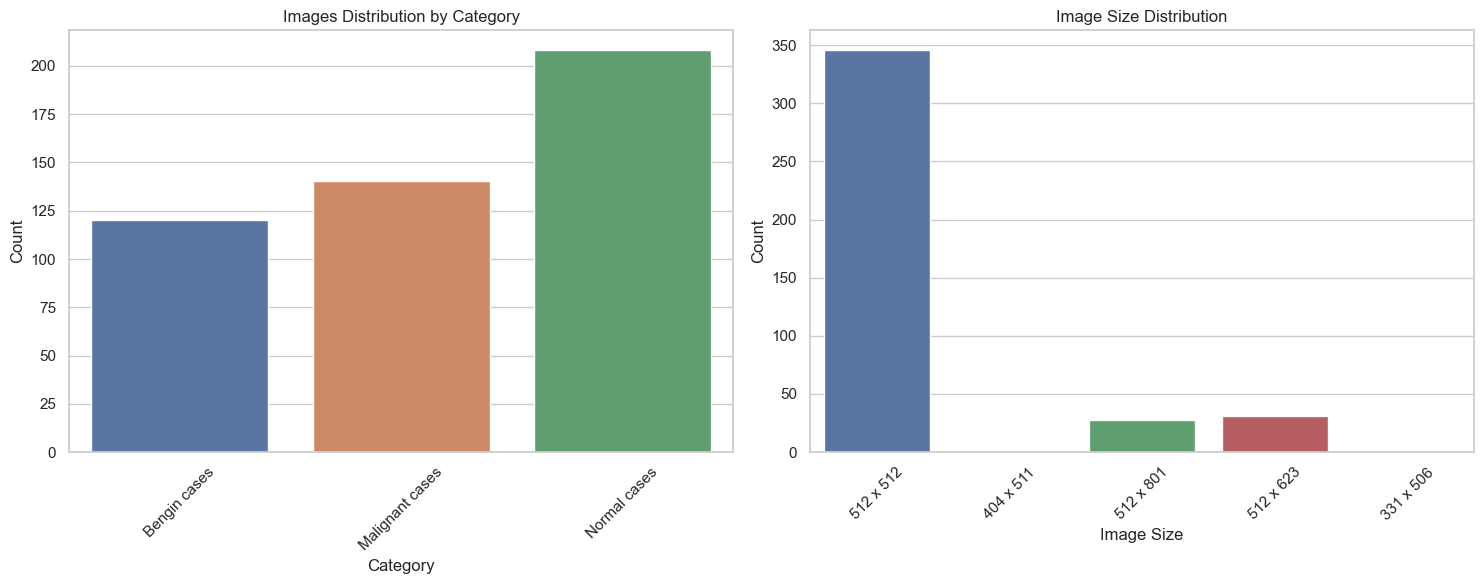

In [46]:
df = pd.DataFrame.from_dict(size_data, orient='index')

# Use Seaborn to create the first bar plot
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
sns.barplot(data=df.T, errorbar=None, ax=ax1)
ax1.set(xlabel='Category', ylabel='Count', title='Images Distribution by Category')
ax1.tick_params(axis='x', rotation=45)

# Use Seaborn to create the second bar plot
sns.set(style="whitegrid")
sns.barplot(data=df, errorbar=None, ax=ax2)
ax2.set(xlabel='Image Size', ylabel='Count', title='Image Size Distribution')
ax2.tick_params(axis='x', rotation=45)

# Adjust the layout of the plots
plt.tight_layout()
plt.show()

In [47]:
image_data = []
image_label = []
IMAGE_SIZE = 512
for i in categories:
    path = directory + '/' + i
    for file in os.listdir(path):
        filepath = path + '/' + file
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(IMAGE_SIZE, IMAGE_SIZE))
        image_data.append(img)
        image_label.append(i)

data/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (1).jpg
data/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (10).jpg
data/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (100).jpg
data/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (101).jpg
data/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (102).jpg
data/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (103).jpg
data/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (104).jpg
data/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (105).jpg
data/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (106).jpg
data/The IQ-O

In [48]:
plt.imshow(image_data[260], cmap="gray")

In [49]:
def show_slices(st,rows,cols):
    fig, axs = plt.subplots(rows,cols,figsize=(rows+5,cols+5))
    axs = axs.flatten()
    for i in range(rows*cols):
        axs[i].imshow(st[i],cmap='gray')
        axs[i].axis('off')
    plt.show()
    
def show(img, title='Image'):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

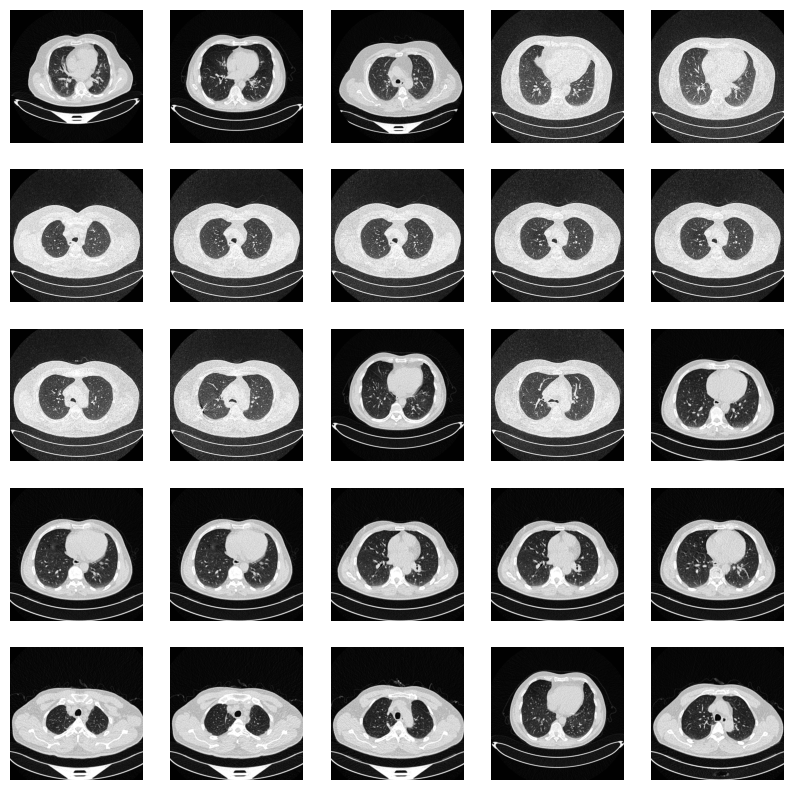

In [50]:
show_slices(image_data, 5, 5)

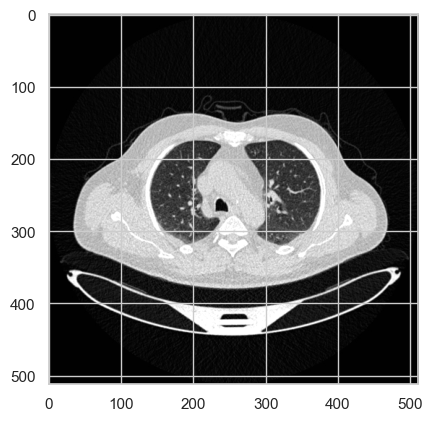

In [51]:
IMAGE_INDEX = 72
plt.imshow(image_data[IMAGE_INDEX], cmap="gray")

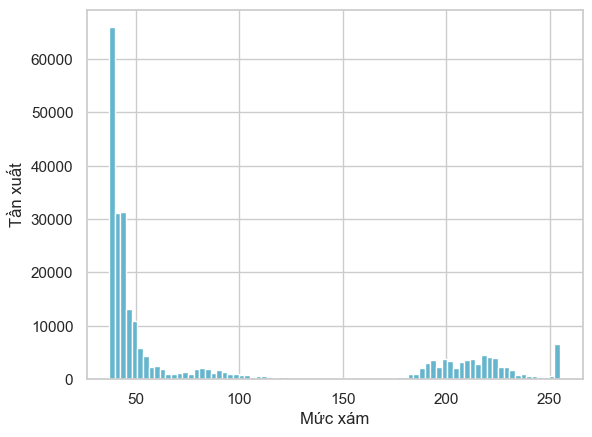

In [52]:
plt.hist(image_data[IMAGE_INDEX].flatten(), bins=80, color='c')
plt.xlabel("Mức xám")
plt.ylabel("Tần xuất")
plt.show()

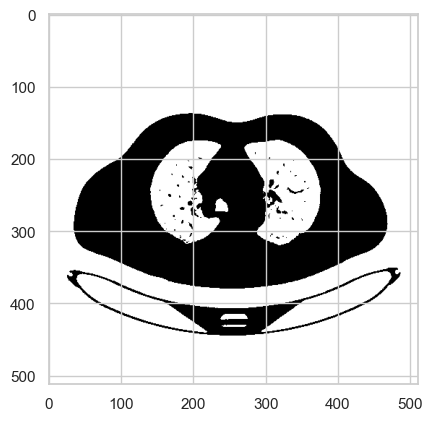

In [53]:
bina = image_data[IMAGE_INDEX] < 150
plt.imshow(bina, cmap="gray")

In [54]:
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import ball, disk, dilation, binary_erosion,remove_small_objects, erosion, closing, reconstruction, binary_closing, opening, binary_opening, binary_dilation
from skimage.filters import roberts, sobel
from scipy import ndimage as ndi

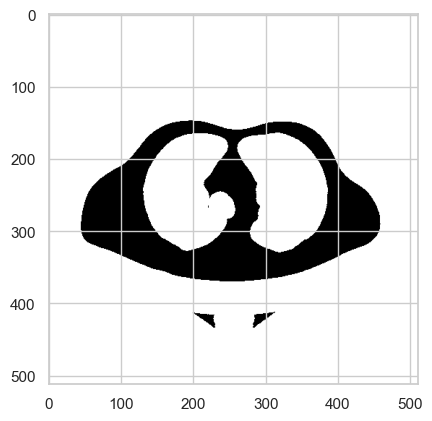

In [55]:
selem = disk(10)
binary = binary_dilation(bina, selem)
plt.imshow(binary, cmap="gray")

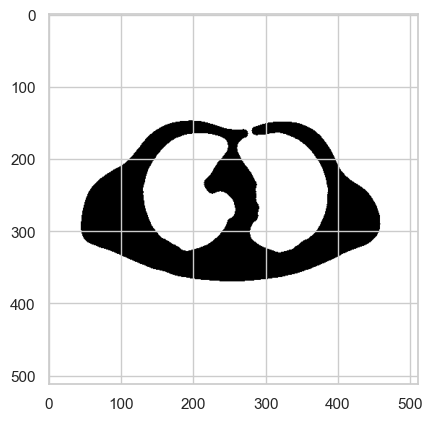

In [56]:
selem = disk(6)
binary = binary_closing(binary, selem)
plt.imshow(binary, cmap="gray")

In [57]:
selem = disk(5)
dilation_img = binary_erosion(binary, selem)
plt.imshow(dilation_img, cmap="gray")

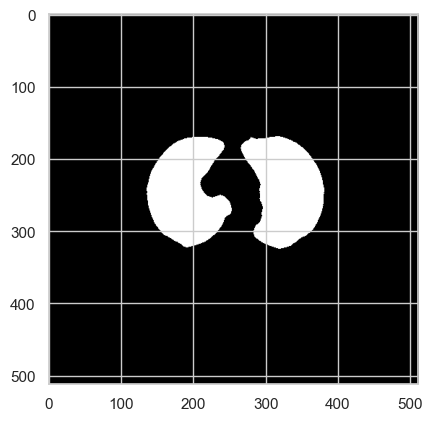

In [58]:
cleared = clear_border(dilation_img)
plt.imshow(cleared, cmap="gray")

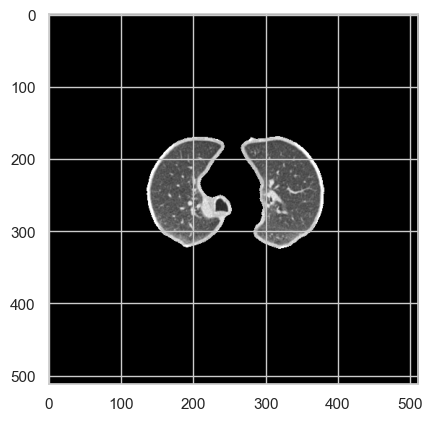

In [59]:
zzz = image_data[IMAGE_INDEX] * cleared
plt.imshow(zzz, cmap="gray")

In [60]:
def plot_img(images, titles, camp='gray', rows = 3, cols = 4, fontsize=50, top=10, right=10):
    plt.subplots_adjust(top=top,right=right)
    for i in range(len(images)):
        #(rows, columns, index)
#         fig, ax = subplots(figsize=(18, 2))
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap=camp)
        plt.title(titles[i], fontsize=fontsize)
        plt.xticks([])
        plt.yticks([])
        
def image_show(image, title, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4,4))
    ax.imshow(image, cmap=cmap)
    ax.set_title(title)
    ax.axis('off')
    return fig, ax

In [61]:
def get_nodules_lungs(im, plot=False):
    
    binary = im < 140
    
    nodules = im.copy()
    
    nodules[nodules < 140] = 0
    if plot == True:
        images = [im, binary, nodules]
        titles = ['Segmented Image', 'Binary Nodules Image', 'Nodules Image']
        plot_img(images, titles, rows = 1, cols = 3, fontsize= 10)
    return nodules

In [62]:
def get_segmented_lungs(im, num, save=False, plot=False, crop_percentage=0.05):
    #This funtion segments the lungs from the given 2D slice.
    
    crop = im.copy()
   
    #Step 1: Crop the image 
    height,width=im.shape[:2]
    start_row,start_col=int(height*0.12),int(width*0.12)
    end_row,end_col=int(height*0.88),int(width*0.88)
    crop=crop[start_row:end_row,start_col:end_col]
        
    #Step 2: Convert into a binary image. 
    ret,binary = cv2.threshold(crop,140,255,cv2.THRESH_BINARY_INV)
    
    #Step 3: Remove the blobs connected to the border of the image.
    cleared = clear_border(binary) 
    
    #Step 4: Closure operation with a disk of radius 10. This operation is 
    #to keep nodules attached to the lung wall.
    selem = disk(2)
    closing = binary_closing(cleared, selem)
        
    #Step 5: Label the image.
    label_image = label(closing)
    
    #Step 6: Keep the labels with 2 largest areas.
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    segmented_area = label_image > 0
        
    #Step 7: seperate the lung nodules attached to the blood vessels.
    selem = disk(2)
    erosion = binary_erosion(segmented_area, selem) 
        
    #Step 8: to keep nodules attached to the lung wall.
    selem = disk(10)
    closing2 = binary_closing(erosion, selem)    
    
    #Step 9: Fill Holé
    edges = roberts(closing2)
    fill_holes = ndi.binary_fill_holes(edges)
        
    superimpose = crop.copy()
    get_high_vals = fill_holes == 0
    superimpose[get_high_vals] = 0

    superimpose = cv2.resize(superimpose, (512, 512))    
    
    
    images = [im, crop, binary, cleared, closing, label_image, segmented_area, erosion, closing2, fill_holes, superimpose]
    
    if plot:
        titles = ['Original Image', 
                 'Step 1: Cropped Image', 
                 'Step 2: Binary image', 
                 'Step 3: Remove blobs', 
                 'Step 4: Closure', 
                 'Step 5: Label', 
                 'Step 6: Region On Interest',
                 'Step 7: Erosion',
                 'Step 8: Closure', 
                 'Step 9: Fill Holes',
                 'Step 10: Result']
        plot_img(images, titles, camp=plt.cm.bone, rows = 3, cols = 4, fontsize= 50)
    
    return superimpose

In [63]:
numOfImg = 1
test = image_data[numOfImg].copy()
get_segmented_lungs(test, numOfImg, plot = True, show_on_window=True, crop_percentage=0.12)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [64]:
X_segmented = np.empty((len(image_data), IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)

for i, img in enumerate(image_data):
    im = img.copy()
    X_segmented[i] = get_segmented_lungs(im, i)

In [65]:
def get_nodules_lungs(im, plot=False):
    
    binary = im < 140
    get_high_vals = binary == 0
    nodules = im.copy()
    nodules[nodules < 140] = 0
    
    if plot == True:
        images = [im, binary, nodules]
        titles = ['Segmented Image', 'Binary Nodules Image', 'Nodules Image']
        plot_img(images, titles, rows = 1, cols = 3, fontsize= 10)
        
    return nodules

In [66]:
test = X_segmented[0].copy()
get_nodules_lungs(test, True)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [67]:
X_nodules = np.empty((len(image_data), IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)

for i, img in enumerate(X_segmented):
    im = img.copy()
    X_nodules[i] = get_nodules_lungs(im)

In [68]:
images = [image_data[0], X_segmented[0], X_nodules[0],
          image_data[24], X_segmented[24], X_nodules[24],
          image_data[48], X_segmented[48], X_nodules[48]]
titles = ['Original Image ' + image_label[0], 'Segmented Image ' + image_label[0], 'Nodules Image ' + image_label[0],
         'Original Image ' + image_label[24], 'Segmented Image ' + image_label[24], 'Nodules Image ' + image_label[24], 
         'Original Image ' + image_label[48], 'Segmented Image ' + image_label[48], 'Nodules Image ' + image_label[48]]
plot_img(images, titles, camp=plt.cm.bone, rows = 3, cols = 3, fontsize= 20, top=3, right=3)

In [245]:
X_segmented.shape

(1097, 512, 512)

In [246]:
hog = cv2.HOGDescriptor()

In [254]:
X = []
for i in X_segmented:
    X.append(hog.compute(img))

In [255]:
X = np.array(X)
X.shape

(1097, 34020)

In [258]:
y = []
for i in image_label:
    if i == 'Bengin cases':
        y.append(0)
    elif i == 'Malignant cases':
        y.append(1)
    else:
        y.append(2)
        
y = np.array(y)
print(y)

[0 0 0 ... 2 2 2]


In [260]:
y.shape

(1097,)

In [147]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(701, 34020)
(176, 34020)
(220, 34020)


In [261]:
from sklearn.ensemble import RandomForestClassifier

randomForestModel = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)

randomForestModel.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [285]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score
y_pred = randomForestModel.predict(X_test)

print(precision_score(y_test, y_pred, average="weighted"))
print(classification_report(y_test, y_pred))

0.6392619479733818
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.74      0.90      0.81       109
           2       0.74      0.78      0.76        82

    accuracy                           0.74       220
   macro avg       0.49      0.56      0.52       220
weighted avg       0.64      0.74      0.68       220



c:\Users\wwwng\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wwwng\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wwwng\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

In [290]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_yticklabels(categories, rotation=0, ha='right')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [142]:
# Save Model
import joblib

joblib.dump(randomForestModel, 'RandomForestClassifier.pkl')

['RandomForestClassifier.pkl']

In [291]:
from sklearn.neighbors import KNeighborsClassifier
kNN = KNeighborsClassifier(n_neighbors=10)
kNN.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [294]:
y_pred = kNN.predict(X_test)


In [295]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.34      0.43        29
           1       0.91      0.94      0.93       109
           2       0.80      0.88      0.84        82

    accuracy                           0.84       220
   macro avg       0.77      0.72      0.73       220
weighted avg       0.83      0.84      0.83       220



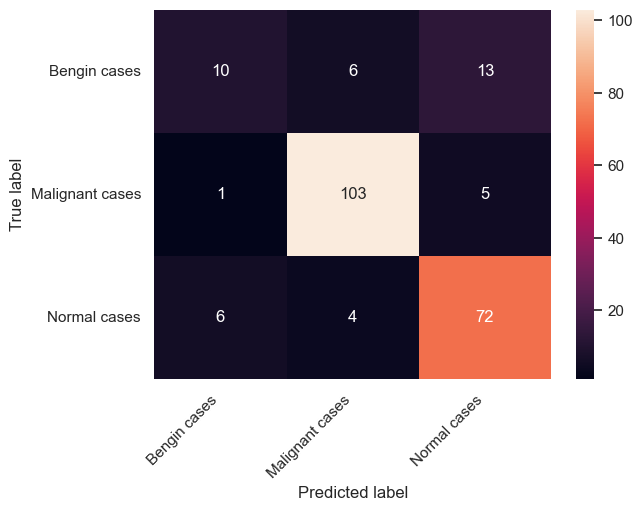

In [296]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_yticklabels(categories, rotation=0, ha='right')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [218]:
joblib.dump(kNN, 'KNN.pkl')

['KNN.pkl']

In [297]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

# Train decision tree classifier on training data
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [219]:
joblib.dump(clf, 'DecisionTreeClassifier.pkl')

['DecisionTreeClassifier.pkl']

In [298]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.45      0.54        29
           1       0.85      0.87      0.86       109
           2       0.78      0.84      0.81        82

    accuracy                           0.80       220
   macro avg       0.77      0.72      0.74       220
weighted avg       0.80      0.80      0.80       220



In [299]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_yticklabels(categories, rotation=0, ha='right')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()